# PyBaMM SPMe Parameter Identification — LS, PSO, DE

**Goal.** Identify SPMe parameters by fitting simulated terminal voltage to measured data under a constant‑current Discharge→Charge experiment.

---

## 📊 Comparison Table (LS vs PSO vs DE)

| Feature                         | Least Squares (LS)                          | Particle Swarm Optimization (PSO)                  | Differential Evolution (DE)                  |
| ------------------------------- | ------------------------------------------- | -------------------------------------------------- | -------------------------------------------- |
| **Library**                     | `scipy.optimize.least_squares`              | `pyswarms`                                         | `scipy.optimize.differential_evolution`      |
| **Nature**                      | Deterministic, gradient-based (local)       | Stochastic, swarm-based (global)                   | Stochastic, evolutionary (global)            |
| **Exploration vs Exploitation** | Mostly exploitation (local search)          | Balance via `c1`, `c2`, `w`                        | Strong exploration, mutation-driven          |
| **Global vs Local**             | Local optimizer (prone to local minima)     | Global optimizer (but can stagnate if swarm small) | Global optimizer, very robust                |
| **Speed**                       | Fastest (uses Jacobians/gradients)          | Slower (needs many evaluations)                    | Often slower than PSO (big populations)      |
| **Parallelization**             | Limited                                     | Possible, but not native                           | Native via `workers` arg                     |
| **Best for**                    | Well-behaved convex or near-convex problems | Problems with moderate nonlinearity, multimodality | Rugged/multimodal problems, highly nonlinear |
| **History tracking**            | Not automatic (need wrapper)                | Built-in (`cost_history`)                          | Via callback                                 |
| **Initialization**              | Needs good initial guess                    | Random swarm over \[0,1]                           | Random population over \[0,1]                |

---

## 🚦 When to Use What?

* **Use LS**:

  * When you trust initial guesses are close to the true solution.
  * When model is smooth & convex-like.
  * You need speed.

* **Use PSO**:

  * When LS fails (local minima trap).
  * When problem is moderately nonlinear, but you don’t want huge population sizes.
  * Good compromise between speed & global search.

* **Use DE**:

  * When the problem is *very rugged* (lots of local minima).
  * When robustness > speed.
  * You can afford more evaluations (e.g., offline parameter fitting).

---

## Optimizers

### Least Squares (LS)
- `scipy.optimize.least_squares` (bounded, trust‑region).
- **Use:** Local search / polishing a global candidate.
- **Trade‑off:** Very fast but can land in local minima if the start is poor.

### Particle Swarm (PSO)
- PySwarms `GlobalBestPSO` (inertia `w`, cognitive `c1`, social `c2`).
- **Use:** Global exploration; stochastic (set a seed).
- **Trade‑off:** More function calls; benefits from objective caching.

### Differential Evolution (DE)
- `scipy.optimize.differential_evolution` (`mutation`, `recombination`, `popsize`).
- **Use:** Robust global search; deterministic with a seed.
- **Trade‑off:** Population methods can be compute‑heavy (parallel workers help).

---

## Optimizers overview

Minimizing a **sum of squared voltage residuals** between measurement and simulation. Let $x \in [0,1]^n$ be the **unit-box** parameters (later mapped to physical ranges). Let

$$
r(x) = V_{\text{meas}}(t_i) \;-\; V_{\text{sim}}(t_i; \theta(x)), \quad i=1,\dots,m
$$

and the objective

$$
J(x)=\tfrac12 \lVert r(x)\rVert_2^2 = \tfrac12 \sum_{i=1}^m r_i(x)^2 .
$$

The physical parameters are obtained by an affine map

$$
\theta_j(x) = \theta^{\text{lo}}_j + x_j \big(\theta^{\text{hi}}_j - \theta^{\text{lo}}_j\big),
$$

which (i) enforces bounds and (ii) **balances scales** so each dimension behaves comparably for the optimizer.

### Least Squares (LS): fast local “polisher”

* **What it solves.** A **nonlinear bounded** least-squares problem

  $$
  \min_{x\in[0,1]^n} \tfrac12\|r(x)\|_2^2.
  $$
* **How it works (TRF).** SciPy’s `method="trf"` uses a **trust-region reflective** scheme. Each iteration builds a local quadratic model via the Jacobian $J_r(x)=\partial r/\partial x$ and solves

  $$
  \min_{\Delta} \;\; \tfrac12\|J_r(x)\,\Delta + r(x)\|_2^2 \quad \text{s.t. } x+\Delta \in [0,1]^n,\; \|\Delta\|\le \rho ,
  $$

  adjusting the trust-region radius $\rho$ and reflecting steps at the bounds when needed.
* **Strengths.** Extremely efficient near a good solution; exploits residual structure; returns Jacobian and convergence diagnostics.
* **Limitations.** **Local** method → sensitive to the starting point (can get stuck in a local basin).
* **Use when.** You already have a decent candidate (e.g., from PSO/DE, or domain-informed initial guess), and you want a precise, fast refinement; or your landscape is smooth and benign.

**Tuning tips**

* Keep the **unit-box scaling** (you already do), it stabilizes the Jacobian.
* `loss="linear"` is standard L2; switch to `"soft_l1"` or `"huber"` if you have outliers.
* Tight `ftol, xtol, gtol` give a meticulous polish; raise `max_nfev` if residuals are still trending down.

---

### Particle Swarm Optimization (PSO): robust global exploration

* **Update rules.** For particle $i$ with position $x_i$ and velocity $v_i$,

  $$
  v_i^{k+1} = w\,v_i^k + c_1\,u_1\odot(p_i^k-x_i^k) + c_2\,u_2\odot(g^k-x_i^k), \qquad
  x_i^{k+1} = x_i^k + v_i^{k+1},
  $$

  where $p_i$ is particle-best, $g$ is global-best, $u_1,u_2\sim \mathcal U(0,1)$, and $\odot$ is elementwise.
* **Strengths.** Few assumptions, handles rugged/multimodal landscapes, simple hyperparameters.
* **Limitations.** Stochastic, typically needs **many** objective evaluations; final steps are not curvature-aware (why we polish with LS).
* **Use when.** You suspect multiple minima, discontinuities in the simulator, or poor initial guesses; you want a **reliable global candidate** before LS.

**Tuning tips**

* Start with $w\in[0.5,0.9]$, $c_1=c_2\in[1.2,2.2]$; use a **seed** for reproducibility.
* Population size $= 10\!-\!20 \times n$ is common; stop when best cost plateaus.
* Objective **caching** helps a lot if your code can memoize duplicates.

---

### Differential Evolution (DE): strong, simple evolutionary search

* **Mutation & crossover.** Pick three distinct individuals $x_{r1},x_{r2},x_{r3}$; form a mutant

  $$
  v = x_{r1} + F\,(x_{r2}-x_{r3}),
  $$

  then binomial crossover with target $x$ to get trial $u$. **Selection:** keep the better of $u$ and $x$.
* **Strengths.** Solid global search with **few knobs**; deterministic with a seed; often finds good basins for LS.
* **Limitations.** Costly in function calls (population × iterations).
* **Use when.** Similar to PSO; DE is often a good default when you want robust global coverage without tuning many parameters.

**Tuning tips**

* `mutation=F≈0.5–0.9`, `recombination=CR≈0.7–0.95`, `popsize≈10–20` (meaning population $=$ `popsize*n`).
* Strategy `"best1bin"` or `"rand1bin"` are reliable starts.
* Increase `maxiter` until the best cost stabilizes.

---

## Choosing among them (rule-of-thumb)

* **Small n, smooth problem, good guess?** → **LS only**.
* **Unknown basin / likely multimodal?** → **PSO or DE → LS** (hybrid).
* **Noisy data / outliers?** → Use LS with robust `loss` **after** global search.
* **Tight runtime budget?** → A **brief** DE/PSO to find a viable basin, then LS.

---

## Why unit-box scaling matters

Let $\theta$ have wildly different magnitudes (e.g., $10^{-14}$ vs $10^2$). Working directly in $\theta$ yields ill-conditioned Jacobians and erratic steps. Mapping $x \in [0,1]^n \mapsto \theta(x)$ makes each dimension comparable and keeps the bounds rectangular, which the LS TRF and PSO/DE handle cleanly.

---

## Hybrid strategy

* **Global stage (PSO/DE):** roam the space, land near a promising basin.
* **Local stage (LS):** precisely minimize $J(x)$ inside that basin.
* This pairing gives **robustness (global)** + **speed/accuracy (local)**.

---

## Mathematical details of the LS step

* **Objective:**

  $$
  \min_{x\in[0,1]^n} \tfrac12\|r(x)\|_2^2.
  $$
* **Gauss–Newton / TRF step:** given $J_r=\partial r/\partial x$,

  $$
  \Delta^\star \approx \arg\min_{\Delta} \tfrac12\|J_r\,\Delta + r\|_2^2 \quad \text{s.t.}\;\; x+\Delta\in[0,1]^n,\;\|\Delta\|\le\rho .
  $$

  If the model is mildly nonlinear and the Jacobian is well-conditioned, this converges **quadratically** near the solution.
* **Stopping tests (SciPy):**

  * `ftol`: small change in $J$,
  * `xtol`: small change in $x$,
  * `gtol`: small projected gradient $\|J_r^\top r\|$.

---

In [19]:
# SPMe Parameter Identification (PyBaMM) — LS, PSO, DE
# ----------------------------------------------------
# Single canonical params dict; clean helpers; robust objective; optional caching;
# PSO/DE histories; overlays and convergence plots.
#
# Requirements:
#   - pybamm
#   - scipy
#   - matplotlib
#   - pyswarms (for PSO, optional)


# • PyBaMM uses consistent SI units.
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache
from scipy.interpolate import interp1d
from scipy.optimize import least_squares, differential_evolution
import pybamm
import math


# ------------------------- #
# Plotting defaults         #
# ------------------------- #
plt.rcParams.update({
    "figure.figsize": (7.6, 4.4),
    "axes.grid": False,
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

In [20]:
# ==== Bounding mode toggle ====
# 'box'    : use your current unit-cube [0,1]^n with ±pct physical bounds
# 'logfree': unconstrained (R^n) in log-space: p = p0 * exp(z)
BOUNDING_MODE = "logfree"      # mode 'box' and 'logfree' are both supported
BOX_PCT = 0.30             # used only when BOUNDING_MODE == "box"
# If you want “looser” bounds without the log trick → keep "box" and change a single line:
# lower_phys, upper_phys = make_bounds_from_template(params, vary_keys, pct=5.0) (±500%).

LOGFREE_SPAN = 6.0         # PSO/DE finite span for z in [-6, +6] -> ~x403 range
BOUND01_KEYS = ("tplus", "theta_n0", "theta_p0")  # map to (0,1) via sigmoid if varied


In [21]:
p = pybamm.ParameterValues("Ai2020")
try:
    print(len(p.values))                 # works on many versions
except Exception:
    try:
        print(len(p.parameter_values))   # older versions
    except Exception:
        print(len(dict(p)))              # if ParameterValues is Mapping
        

print([k for k in p.keys()][:100]) # categories


130
['Ideal gas constant [J.K-1.mol-1]', 'Faraday constant [C.mol-1]', 'Boltzmann constant [J.K-1]', 'Electron charge [C]', 'Ratio of lithium moles to SEI moles', 'SEI partial molar volume [m3.mol-1]', 'SEI reaction exchange current density [A.m-2]', 'SEI resistivity [Ohm.m]', 'SEI solvent diffusivity [m2.s-1]', 'Bulk solvent concentration [mol.m-3]', 'SEI open-circuit potential [V]', 'SEI electron conductivity [S.m-1]', 'SEI lithium interstitial diffusivity [m2.s-1]', 'Lithium interstitial reference concentration [mol.m-3]', 'Initial SEI thickness [m]', 'Initial SEI on cracks thickness [m]', 'EC initial concentration in electrolyte [mol.m-3]', 'EC diffusivity [m2.s-1]', 'SEI kinetic rate constant [m.s-1]', 'SEI growth activation energy [J.mol-1]', 'Negative electrode reaction-driven LAM factor [m3.mol-1]', 'Positive electrode reaction-driven LAM factor [m3.mol-1]', 'Negative current collector thickness [m]', 'Negative electrode thickness [m]', 'Separator thickness [m]', 'Positive elec

In [22]:
# ---------------------------------------------------------- #
# 1) Keys for optimization (8 variables) and parameters dict #
# ---------------------------------------------------------- #

# Optimized parameters (From Seong Beom Lee and Simona Onori 2021 paper):
# _________________________________________________________________________
# Electrolyte diffusion coefficient D(m²/s) 
# Electrolyte conductivity 𝜅(S/m) # can estimate either D
# Solid phase conductivity (positive) σp(S/m) 
# Solid phase conductivity (negative) σn(S/m)
# Solid diffusivity (positive) Ds,p(m²/s) Dsp are related to sigmap
# Solid diffusivity (negative) Ds,n(m²/s) Dsn are related to sigman
# Reaction rate constant (positive) 𝑘p(mol/(m²·s)) 
# Reaction rate constant (negative) 𝑘n(mol/(m²·s))

vary_keys = ["D1", "Kappa", "sigmap", "sigman", "Dsp", "Dsn", "kp", "kn",
            #  # geometry & particle (positive → logfree-safe)
            # "Ln", "Ls", "Lp", "Rp_n", "Rp_p", "A",
            # # capacities / electrolyte
            # "csmax_n", "csmax_p",
            # # electrolyte transference (bounded 0..1)
            # "tplus",
            # # initial stoichiometries (bounded 0..1)
            # "theta_n0", "theta_p0",
    ]


params = dict(
    # Geometry (paper)
    Ln=85.2e-6, Ls=12e-6, Lp=75.6e-6,
    A=0.11,         # m^2 (paper uses electrode area)
    Nx=80, Nr=20,

    # Porosities (paper)
    eps_e={"n": 0.25, "s": 0.47, "p": 0.335},

    # Electrolyte + solid conductivities & diffusivities (to be optimized)
    D1=7.2296e-10,              # electrolyte diffusivity [m^2/s]
    Kappa=1.0794,               # electrolyte conductivity [S/m]
    sigmap=0.2029,              # solid conductivity (pos) [S/m]
    sigman=150.5000,            # solid conductivity (neg) [S/m]
    Dsp=5.2000e-15,             # solid particle diffusivity (pos) [m^2/s]
    Dsn=3.9750e-14,             # solid particle diffusivity (neg) [m^2/s]
    kp=8.6225e-12,              # reaction rate (pos) [m^2.5 mol^-0.5 s^-1]
    kn=5.9673e-13,              # reaction rate (neg) [m^2.5 mol^-0.5 s^-1]

    # Radius of solid particle
    Rp_n=5.86e-6, Rp_p=5.22e-6,

    # Max concentrations (paper)
    csmax_n=29583.0, csmax_p=51765.0,

    # Electrolyte / transference
    tplus=0.363,

    # Initial stoichiometries
    theta_n0=0.90, theta_p0=0.27,

    # Experiment / solver
    n_cycles=2,
    # I_cc=(5.0/3600.0)/0.11,   # 1C on 5Ah cell over 0.11 m^2 → A = (5Ah / 1h)/A_cell (paper)
    I_cc=5.0,
    Vmin=2.7, Vmax=4.2, dt=0.05,
)





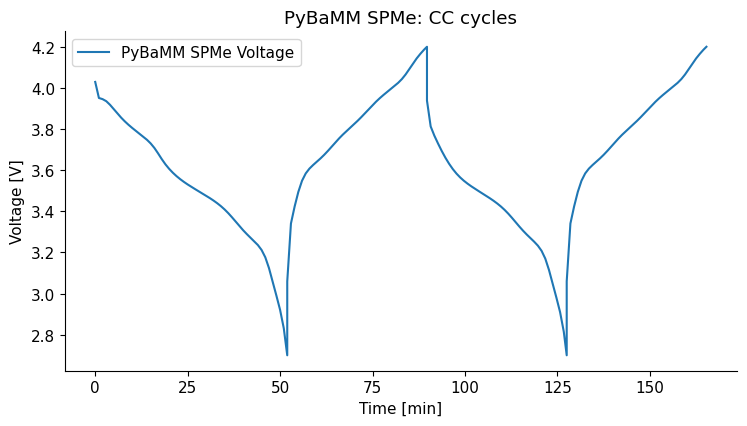

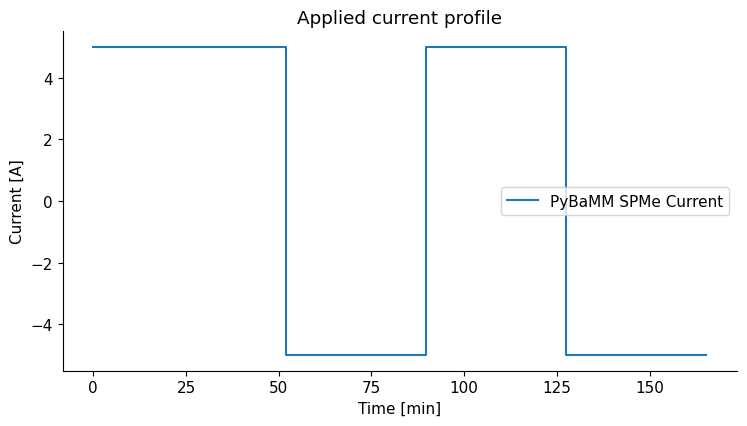

In [ ]:
# ----------------------------------------------------- #
# 2) SPMe model: param mapping, experiment, run, plots  #
# ----------------------------------------------------- #

def build_params_from_dict(d: dict) -> pybamm.ParameterValues:
    """
    Map a plain Python parameters dict into `pybamm.ParameterValues` for SPMe.

    The dict `d` uses short names (D1, Kappa, sigmap, ...) and this function
    binds them to the model's expected parameter names, preserving SI units.

    Parameters
    ----------
    d : dict
        Full parameter dictionary including geometry, porosities, transport,
        particle radii, max concentrations, initial stoichiometries, kinetics,
        and experiment/solver scalars.

    Returns
    -------
    pybamm.ParameterValues
        Ready-to-use parameter set for a `pybamm.Simulation`.
    """
    base = pybamm.ParameterValues("Chen2020") # this is the parameter set used in the paper

    # Geometry & area
    Ln, Ls, Lp = d["Ln"], d["Ls"], d["Lp"]
    A = d["A"]

    # Initial concentrations from stoichiometries
    c_n0 = d["theta_n0"] * d["csmax_n"]
    c_p0 = d["theta_p0"] * d["csmax_p"]

    updates = {
        # geometry & area
        "Negative electrode thickness [m]": Ln,
        "Separator thickness [m]": Ls,
        "Positive electrode thickness [m]": Lp,
        "Electrode area [m2]": A,

        # porosity
        "Negative electrode porosity": d["eps_e"]["n"],
        "Separator porosity": d["eps_e"]["s"],
        "Positive electrode porosity": d["eps_e"]["p"],

        # electrolyte transport (constant)
        "Electrolyte diffusivity [m2.s-1]": d["D1"],
        "Electrolyte conductivity [S.m-1] (ref)": d["Kappa"],
        "Cation transference number": d["tplus"],

        # solid transport (diffusivity)
        "Negative electrode diffusivity [m2.s-1]": d["Dsn"],
        "Positive electrode diffusivity [m2.s-1]": d["Dsp"],

        # electronic conductivities
        "Negative electrode conductivity [S.m-1]": d["sigman"],
        "Positive electrode conductivity [S.m-1]": d["sigmap"],

        # particle radii
        "Negative particle radius [m]": d["Rp_n"],
        "Positive particle radius [m]": d["Rp_p"],

        # concentrations & initial conditions
        "Maximum concentration in negative electrode [mol.m-3]": d["csmax_n"],
        "Maximum concentration in positive electrode [mol.m-3]": d["csmax_p"],
        "Initial concentration in negative electrode [mol.m-3]": c_n0,
        "Initial concentration in positive electrode [mol.m-3]": c_p0,

        # kinetics (Butler–Volmer)
        "Negative electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kn"],
        "Positive electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kp"],

        # temperature (isothermal)
        "Ambient temperature [K]": 298.15,
        "Reference temperature [K]": 298.15,
    }

    base.update(updates, check_already_exists=False)
    return base


def make_experiment(d: dict) -> pybamm.Experiment:
    """
    Create a CC Discharge→Charge PyBaMM experiment, repeated for `n_cycles`.

    Parameters
    ----------
    d : dict
        Must contain: I_cc [A], Vmin [V], Vmax [V], optionally n_cycles.

    Returns
    -------
    pybamm.Experiment
        A simple two-step CC experiment repeated `n_cycles` times.
    """
    I = abs(float(d["I_cc"]))        # A
    Vmin, Vmax = d["Vmin"], d["Vmax"]
    n_cycles = int(d.get("n_cycles", 1))
    steps = [f"Discharge at {I} A until {Vmin} V",
             f"Charge at {I} A until {Vmax} V"] * n_cycles


    # # Optional: add a small rest after each step to help compare plateaus
    # steps = [f"Discharge at {I} A until {Vmin} V", "Rest for 5 seconds",
    #          f"Charge at {I} A until {Vmax} V", "Rest for 5 seconds"] * n_cycles


    return pybamm.Experiment(steps)


def run_spme(d: dict):
    """
    Build and solve the SPMe with parameters in `d`.

    Parameters
    ----------
    d : dict
        Full parameter dictionary (geometry, porosity, transport, kinetics, etc.).

    Returns
    -------
    (sol, sim) : (pybamm.Solution, pybamm.Simulation)
        The solved solution and the simulation object.
    """
    model = pybamm.lithium_ion.SPMe(options={
        "surface form": "algebraic",
        "thermal": "isothermal",
        "SEI": "none",
        "lithium plating": "none",
    })
    param = build_params_from_dict(d)

    # Discretisation controls
    # var_pts = {
    #     "x_n": max(10, d.get("Nx", 80)//6),
    #     "x_s": max(6, d.get("Nx", 80)//10),
    #     "x_p": max(10, d.get("Nx", 80)//6),
    #     "r_n": max(10, d.get("Nr", 20)),
    #     "r_p": max(10, d.get("Nr", 20)),
    # }
    
    var_pts = {
    "x_n": 20,
    "x_s": 15,
    "x_p": 20,
    "r_n": 30,
    "r_p": 30,
    }

    # Experiment
    experiment = make_experiment(d)

    # Solver: use Casadi for speed; set max timestep based on your dt
    dt = float(d.get("dt", 0.05))
    # solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6, dt_max=dt)
    try:
        solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6, dt_max=dt)
    except Exception:
        solver = pybamm.ScipySolver(atol=1e-6, rtol=1e-6, mode="safe")



    # Simulate
    sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment,
                             var_pts=var_pts, solver=solver)
    sol = sim.solve()

    return sol, sim


def plot_results(sol: pybamm.Solution, label_prefix: str = "PyBaMM SPMe") -> None:
    """
    Quick plots of terminal voltage and current vs time.

    Parameters
    ----------
    sol : pybamm.Solution
        Solution returned by `run_spme`.
    label_prefix : str, optional
        Text prefix used in the legend labels.
    """
    t = sol["Time [s]"].entries
    V = sol["Terminal voltage [V]"].entries
    I = sol["Current [A]"].entries

    plt.figure()
    plt.plot(t/60, V, label=f"{label_prefix} Voltage")
    plt.xlabel("Time [min]"); plt.ylabel("Voltage [V]")
    plt.title("PyBaMM SPMe: CC cycles")
    plt.legend(); plt.tight_layout()

    plt.figure()
    plt.plot(t/60, I, label=f"{label_prefix} Current")
    plt.xlabel("Time [min]"); plt.ylabel("Current [A]")
    plt.title("Applied current profile")
    plt.legend(); plt.tight_layout()




sol, sim = run_spme(params)
plot_results(sol)
plt.show()


In [24]:
# -------------------------------------------- #
# 3) Bounds, scaling, simulation helper utils  #
# -------------------------------------------- #

 
# From the paper (Matlab implementation)
# %% PSO identificaiton (Input your uppoer and lower bounds for parameters to be identified.)

# pp=0.3;                   % Deviation for upper and lower bounds (percentage)
# D10=1;                    % Electrolyte diffusion coefficient  
# Kappa0=1.17;              % Conductivity
# sigmap0=0.18;             % Solid phase conductivity at positive
# sigman0=215;              % Solid phase conductivity at negative
# Dsp0=4;                   % Solid particle diffusivity at positive
# Dsn0=3.3;                 % Solid particle diffusivity at negative
# kp0=0.7;                  % Reaction rate constant at positive
# kn0=0.7;                  % Reaction rate constant at negative
# Lower_bound = [D10-pp*D10 Kappa0-pp*Kappa0 sigmap0-pp*sigmap0 sigman0-pp*sigman0 Dsp0-pp*Dsp0 Dsn0-pp*Dsn0 kp0-pp*kp0 kn0-pp*kn0];
# Upper_bound = [D10+pp*D10 Kappa0+pp*Kappa0 sigmap0+pp*sigmap0 sigman0+pp*sigman0 Dsp0+pp*Dsp0 Dsn0+pp*Dsn0 kp0+pp*kp0 kn0+pp*kn0]; 

def make_bounds_from_template(template: dict, keys: list[str], pct: float = 1):
    """
    Build symmetric physical-space bounds as ±`pct` around template values.
    Example: pct=0.30 →  ±30% around each nominal value.

    Parameters
    ----------
    template : dict
        Nominal dictionary (e.g., paper values) containing all `keys`.
    keys : list[str]
        Parameter names to bound.
    pct : float
        Fractional deviation; 0.30 means ±30%.

    Returns
    -------
    lower : np.ndarray
        Lower bounds (physical units), shape (n_keys,)
    upper : np.ndarray
        Upper bounds (physical units), shape (n_keys,)
    """
    lower = np.array([template[k] * (1 - pct) for k in keys], dtype=float)
    upper = np.array([template[k] * (1 + pct) for k in keys], dtype=float)
    return lower, upper


# def to_unit_space(pd: dict, lower: np.ndarray, upper: np.ndarray, keys=vary_keys) -> np.ndarray:
#     """
#     Map physical dictionary -> unit-space vector x ∈ [0,1]^n via affine scaling:
#     Forward (physical → unit):
#         Rescale each parameter to unit space with an affine map:
#         xi = (P_i - P_i,min) / (P_i,max - P_i,min)  ∈ [0,1]

#     Parameters
#     ----------
#     pd : dict
#         Physical parameters (must contain `keys`).
#     lower, upper : np.ndarray
#         Physical bounds for each parameter.
#     keys : list[str]
#         Parameter names in consistent order.

#     Returns
#     -------
#     x : np.ndarray
#         Unit-space vector.
#     """
#     x = []
#     for k, lo, hi in zip(keys, lower, upper):
#         x.append((pd[k] - lo) / (hi - lo))
#     return np.array(x, dtype=float)


def to_physical_space(template: dict, x_vec: np.ndarray,
                lower: np.ndarray, upper: np.ndarray, keys=vary_keys) -> dict:
    """
    Map unit-space vector x ∈ [0,1]^n -> physical dictionary via:  
    Backward (unit → physical):
        Convert a candidate vector x ∈ [0,1]^8 back to physical values:
        P_i = P_i,min + x_i * (P_i,max - P_i,min)
        Reaction rate constant (negative) 𝑘n(mol/(m²·s))
        Why it helps: the optimizer now works in a balanced box [0,1]^8. Parameters with wildly different magnitudes (e.g., Dsn​ ∼ 10^-14 vs σn ∼ 10^2) 
        no longer skew step sizes and are rescaled to a common range.

    Parameters
    ----------
    template : dict
        Baseline dictionary; all values are copied and only `keys` are updated.
    x_vec : np.ndarray
        Unit-space vector.
    lower, upper : np.ndarray
        Physical bounds for each parameter (same order as `keys`).
    keys : list[str]
        Parameter names in consistent order.

    Returns
    -------
    d : dict
        New dictionary with updated physical parameters.
    """
    d = dict(template)
    for k, xv, lo, hi in zip(keys, x_vec, lower, upper):
        d[k] = float(lo + xv * (hi - lo))
    return d

def map_x_to_physical(template: dict, x_vec: np.ndarray,
                      lower: np.ndarray, upper: np.ndarray, keys=vary_keys) -> dict:
    """
    Dispatch mapping based on BOUNDING_MODE:
      - 'box'    : unit x in [0,1]^n  -> affine to [lower, upper]
      - 'logfree': z in R^n           -> p = p0 * exp(z)  (positive params)
                   keys in BOUND01_KEYS are mapped with sigmoid to (0,1)
    """
    mode = globals().get("BOUNDING_MODE", "box")
    if mode == "box":
        # Fallback if None was passed from plotting/util code
        if lower is None or upper is None:
            lower = globals().get("_GLOBAL_LOWER", None)
            upper = globals().get("_GLOBAL_UPPER", None)
        if lower is None or upper is None:
            raise ValueError("Box mapping requires lower/upper bounds.")
        return to_physical_space(template, x_vec, lower, upper, keys)

    # logfree mode: treat x_vec as z (real)
    d = dict(template)
    for k, z in zip(keys, x_vec):
        z = float(z)
        if k in BOUND01_KEYS:
            d[k] = 1.0 / (1.0 + np.exp(-z))  # clamp into (0,1)
        else:
            base = float(template[k]) if abs(template[k]) > 0 else 1.0
            d[k] = base * np.exp(z)          # multiplicative, >0
    return d




def simulate_voltage(params_dict: dict):
    """
    Simulate the SPMe and return time, terminal voltage, and current.
    Takes a physical parameter dict, runs your SPMe, and returns arrays for time, voltage, current.

    Parameters
    ----------
    params_dict : dict
        Full set of physical parameters passed to `run_spme`.

    Returns
    -------
    t_sim : np.ndarray
        Time [s]
    V_sim : np.ndarray
        Terminal voltage [V]
    I_sim : np.ndarray
        Current [A]
    """
    sol, _ = run_spme(params_dict)
    t = sol["Time [s]"].entries
    V = sol["Terminal voltage [V]"].entries
    I = sol["Current [A]"].entries
    return t, V, I


def align_to(t_src: np.ndarray, y_src: np.ndarray, t_dst: np.ndarray, fill_value="extrapolate"):
    """

    Notes
    -----
    Even with simulated “measured” data, event cutoffs can shift the solver’s internal time grid.

    Even with the same experiment, different parameter sets can lead the solver
    to take slightly different internal time steps. This keeps the residuals
    comparable on a common time grid (t_dst).
    
    Why alignment is still needed here
    Even though your “measurement” is simulated, the experiment has cutoffs (“until Vmin/Vmax”). 
    Different parameters will reach the cutoff at slightly different times → different time grids/lengths. Without aligning simulated voltage to t_meas, 
    your residual vector shapes won’t match (or you’ll compare mismatched points). Alignment fixes that cleanly.
    """
    f = interp1d(t_src, y_src, kind="linear", bounds_error=False, fill_value=fill_value)
    return f(t_dst)


In [25]:
# ------------------------------------------ #
# 4) Residuals & objective (with caching)    #
# ------------------------------------------ #


def V_error(x_vec: np.ndarray,
                     V_meas: np.ndarray,
                     t_meas: np.ndarray,
                     template_params: dict,
                     lower_phys: np.ndarray,
                     upper_phys: np.ndarray,
                     keys=vary_keys,
                     penalty: float = 1e3) -> np.ndarray:
    """
    Residuals for least_squares in unit space (x ∈ [0,1]^n).

    Parameters
    ----------
    x_vec : np.ndarray
        Unit-space candidate vector.
    t_meas : np.ndarray
        Measurement time stamps [s].
    V_meas : np.ndarray
        Measured terminal voltage [V].
    template_params : dict
        Baseline parameter dictionary to be updated by x_vec.
    lower_phys, upper_phys : np.ndarray
        Physical-space bounds corresponding to x_vec.
    keys : list[str]
        Parameter names (consistent order).
    penalty : float
        Residual magnitude to return if simulation fails.

    Returns
    -------
    residuals : np.ndarray
        (V_meas - V_sim)
    """
    # Map unit → physical
    pd = map_x_to_physical(template_params, x_vec, lower_phys, upper_phys, keys)
    
    # Run model
    try:
        t_sim, V_sim, _ = simulate_voltage(pd)
    except Exception as e:
        # Penalize failed sims with a big residual shaped like the data
        # (helps the optimizer move away from this region)
        return np.full_like(V_meas, penalty, dtype=float)

    # Align simulated voltage onto the measurement time grid
    if (t_sim.shape != t_meas.shape) or (not np.allclose(t_sim, t_meas)):
        V_sim = align_to(t_sim, V_sim, t_meas)

    return (V_meas - V_sim).astype(float)


def V_objective_scalar(x_vec: np.ndarray,
                       V_meas: np.ndarray,
                       t_meas: np.ndarray,
                       template_params: dict,
                       lower_phys: np.ndarray,
                       upper_phys: np.ndarray,
                       keys=vary_keys) -> float:
    """
    Canonical scalar objective: sum of squares of the voltage residuals.

    This is the recommended objective for PSO/DE/global search. Least-squares
    directly uses the residual vector `V_error` for a more efficient solve.

    Returns
    -------
    float
        Sum of squared residuals.
    """
    res = V_error(
        x_vec=x_vec,
        V_meas=V_meas,
        t_meas=t_meas,
        template_params=template_params,
        lower_phys=lower_phys,
        upper_phys=upper_phys,
        keys=keys,
        penalty=1e3,  # keep big so failed sims are strongly discouraged
    )
    # L2^2 keeps the scale additive across points
    return float(np.dot(res, res))

# ------------------------------ #
# ---- Optional caching wrapper (disabled unless you pass use_cache=True) ----
def _quantize(x: np.ndarray, ndp: int = 6) -> tuple:
    """
    Round a vector to `ndp` decimals and return a tuple (cache key).

    Rounding clusters near-duplicate points so they hit the cache.
    """
    return tuple(np.round(np.asarray(x, float), ndp))


@lru_cache(maxsize=2048)
def _objective_cached(qx: tuple, V_meas_key: int, t_meas_key: int,
                      template_params_key: int, lower_key: int, upper_key: int, keys_key: int) -> float:
    """
    Cached objective backend. The *_key integers allow you to invalidate
    the cache when swapping datasets without hashing large arrays.

    Notes
    -----
    This function relies on module-level globals set by the user.
    """
    x_vec = np.array(qx, dtype=float)
    return V_objective_scalar(x_vec, _GLOBAL_V_MEAS, _GLOBAL_T_MEAS,
                              _GLOBAL_TEMPLATE, _GLOBAL_LOWER, _GLOBAL_UPPER, _GLOBAL_KEYS)


def V_objective_scalar_cached(x_vec: np.ndarray) -> float:
    """
    Cached wrapper for the scalar objective. Enable by passing `use_cache=True`
    to PSO/DE. Make sure to set the module-level globals beforehand.
    """
    return _objective_cached(_quantize(x_vec), 0, 0, 0, 0, 0, 0)


def clear_objective_cache() -> None:
    """
    Clear the LRU cache used by `V_objective_scalar_cached`.

    Call this after changing `t_meas`, `V_meas`, bounds, or the base params.
    """
    _objective_cached.cache_clear()

#------------------------------- #

In [26]:
# ------------------------------- #
# 5) Optimizers: LS, PSO, and DE  #
# ------------------------------- #

def compute_param_errors(est: dict, truth: dict, keys=vary_keys):
    """
    Compute absolute and relative errors for each parameter in `keys`.

    Parameters
    ----------
    est : dict
        Estimated parameters.
    truth : dict
        Ground truth (or nominal) parameters to compare with.
    keys : list[str]
        Ordered parameter names to evaluate.

    Returns
    -------
    (abs_err, rel_err) : (dict, dict)
        Dicts keyed by parameter name.
    """
    tiny = 1e-30
    abs_err = {k: abs(est[k] - truth[k]) for k in keys}
    rel_err = {k: abs(est[k] - truth[k]) / max(abs(truth[k]), tiny) for k in keys}
    return abs_err, rel_err

# def run_least_squares(t_meas: np.ndarray,
#                       V_meas: np.ndarray,
#                       template_params: dict,
#                       lower_phys: np.ndarray,
#                       upper_phys: np.ndarray,
#                       keys=vary_keys,
#                       n_starts: int = 5,
#                       seed: int | None = 0,
#                       max_nfev: int = 80,
#                       tol: float = 1e-9,
#                       truth_for_eval: dict | None = None,
#                       record_path: bool = True):
#     """
#     Multi-start bounded least-squares in unit space using `scipy.optimize.least_squares`.

#     Each start samples a random x0 ∈ [0,1]^n and solves using the residual
#     vector from `V_error`. Returns the best run plus a per-start log.

#     Parameters
#     ----------
#     t_meas, V_meas : np.ndarray
#         Measurement time grid and voltage samples.
#     template_params : dict
#         Baseline physical parameter dictionary updated by x during solves.
#     lower_phys, upper_phys : np.ndarray
#         Physical-space bounds arrays for `keys`.
#     keys : list[str], optional
#         Parameter names (length n).
#     n_starts : int, optional
#         Number of random initializations.
#     seed : int | None, optional
#         RNG seed for repeatability; set None for non-deterministic starts.
#     max_nfev : int, optional
#         Function evaluation cap per start.
#     tol : float, optional
#         Termination tolerances (ftol, xtol, gtol).
#     truth_for_eval : dict | None, optional
#         If provided, error metrics vs truth are recorded per run.

#     Returns
#     -------
#     (best_est_params, best_result, runs) : (dict, OptimizeResult, list[dict])
#         The best physical-parameter dict, the SciPy result, and the per-start log.
#     """
#     rng = np.random.default_rng(seed)
#     n_dim = len(keys)
    
#     if BOUNDING_MODE == "box":
#         bounds = (np.zeros(n_dim), np.ones(n_dim))
#         sampler = lambda: rng.uniform(0.0, 1.0, size=n_dim)

#     else:  # logfree
#         bounds = (-np.inf * np.ones(n_dim), np.inf * np.ones(n_dim))
#         sampler = lambda: rng.normal(loc=0.0, scale=0.2, size=n_dim)  # small exp-perturb

#     best = None
#     runs = []

#     for i in range(n_starts):
#         # x0 = rng.uniform(0.0, 1.0, size=len(keys))
#         x0 = sampler()
#         res = least_squares(
#             V_error, x0,
#             bounds=bounds,
#             args=(V_meas, t_meas, template_params, lower_phys, upper_phys, keys),
#             method="trf" if np.isfinite(bounds[0]).all() else "lm",  # 'lm' ignores bounds,
#             loss="linear",
#             ftol=tol, xtol=tol, gtol=tol,
#             max_nfev=max_nfev,
#         )
#         normr = float(np.linalg.norm(res.fun))
#         xhat = res.x
#         est_params = map_x_to_physical(template_params, xhat, lower_phys, upper_phys, keys)

#         rec = {
#             "start": i + 1,
#             "x0_unit": x0,
#             "xhat_unit": xhat,
#             "residual_norm_2": normr,
#             "status": int(res.status),
#             "est_params": {k: float(est_params[k]) for k in keys},
#         }
#         if truth_for_eval is not None:
#             abs_err, rel_err = compute_param_errors(est_params, truth_for_eval, keys)
#             rec["abs_err"] = {k: float(abs_err[k]) for k in keys}
#             rec["rel_err"] = {k: float(rel_err[k]) for k in keys}

#         runs.append(rec)
#         print(f"[start {i+1}/{n_starts}] ||res||_2={normr:.6g} status={res.status}")

#         if (best is None) or (normr < np.linalg.norm(best.fun)):
#             best = res

#     best_est_params = map_x_to_physical(template_params, best.x, lower_phys, upper_phys, keys)
#     return best_est_params, best, runs

def run_least_squares(t_meas: np.ndarray,
                      V_meas: np.ndarray,
                      template_params: dict,
                      lower_phys: np.ndarray,
                      upper_phys: np.ndarray,
                      keys=vary_keys,
                      n_starts: int = 5,
                      seed: int | None = 0,
                      max_nfev: int = 80,
                      tol: float = 1e-9,
                      truth_for_eval: dict | None = None,
                      record_path: bool = True):
    """
    Multi-start LS; records a compact per-run trajectory by wrapping the residual
    function and storing x whenever the cost decreases (accepted improvement).
    """
    rng = np.random.default_rng(seed)
    n_dim = len(keys)

    # Mode-dependent setup
    if 'BOUNDING_MODE' in globals() and BOUNDING_MODE == "logfree":
        # sampler = lambda: rng.normal(loc=0.0, scale=0.2, size=n_dim)
        method = "trf"          # unconstrained
        bounds = (np.zeros(n_dim), np.ones(n_dim))          # IMPORTANT: no bounds with 'lm'
    else:
        # sampler = lambda: rng.uniform(0.0, 1.0, size=n_dim)
        method = "trf"
        bounds = (np.zeros(n_dim), np.ones(n_dim))

    best = None
    runs = []

    for i in range(n_starts):
        # x0 = sampler()
        x0 = rng.uniform(0.0, 1.0, size=len(keys))

        # Per-run trajectory containers
        x_path: list[np.ndarray] = []
        cost_path: list[float] = []

        # Wrap the residual to capture improving steps
        def fun_wrapped(x):
            r = V_error(x, V_meas, t_meas, template_params, lower_phys, upper_phys, keys)
            if record_path:
                ck = float(np.dot(r, r))
                # only store if strictly improves (acts like accepted iterations)
                if (len(cost_path) == 0) or (ck < cost_path[-1] - 1e-12*max(1.0, abs(cost_path[-1]))):
                    x_path.append(np.array(x, dtype=float))
                    cost_path.append(ck)
            return r

        ls_kwargs = dict(
            fun=fun_wrapped,
            x0=x0,
            args=(),                
            method=method,
            loss="linear",
            ftol=tol, xtol=tol, gtol=tol,
            max_nfev=max_nfev,
        )
        if bounds is not None:
            ls_kwargs["bounds"] = bounds

        res = least_squares(**ls_kwargs)

        normr = float(np.linalg.norm(res.fun))
        xhat = res.x
        est_params = map_x_to_physical(template_params, xhat, lower_phys, upper_phys, keys) \
            if 'map_x_to_physical' in globals() else \
            to_physical_space(template_params, xhat, lower_phys, upper_phys, keys)

        rec = {
            "start": i + 1,
            "x0": x0,
            "xhat": xhat,
            "residual_norm_2": normr,
            "status": int(res.status),
            "est_params": {k: float(est_params[k]) for k in keys},
        }
        if record_path:
            rec["x_path"] = x_path
            rec["cost_path"] = cost_path

        if truth_for_eval is not None:
            abs_err, rel_err = compute_param_errors(est_params, truth_for_eval, keys)
            rec["abs_err"] = {k: float(abs_err[k]) for k in keys}
            rec["rel_err"] = {k: float(rel_err[k]) for k in keys}

        runs.append(rec)
        print(f"[start {i+1}/{n_starts}] ||res||_2={normr:.6g} status={res.status}")

        if (best is None) or (normr < np.linalg.norm(best.fun)):
            best = res

    best_est_params = map_x_to_physical(template_params, best.x, lower_phys, upper_phys, keys) \
        if 'map_x_to_physical' in globals() else \
        to_physical_space(template_params, best.x, lower_phys, upper_phys, keys)

    return best_est_params, best, runs




def print_runs_summary(runs, keys=vary_keys, truth=None):
    """
    Console-friendly summary of multi-start LS runs (with optional rel. errors).

    Parameters
    ----------
    runs : list[dict]
        Per-start records returned by `run_least_squares`.
    keys : list[str]
        Parameter names for column order.
    truth : dict | None
        If provided, relative errors are printed per parameter.
    """
    print("\n=== Multi-start summary ===")
    header = ["start", "||res||_2"] + [f"est_{k}" for k in keys]
    if truth is not None:
        header += [f"rel_err_{k}" for k in keys]
    print(" | ".join(f"{h:>14s}" for h in header))
    for r in runs:
        row = [f"{r['start']:>14d}", f"{r['residual_norm_2']:>14.6g}"]
        row += [f"{r['est_params'][k]:>14.6g}" for k in keys]
        if truth is not None and "rel_err" in r:
            row += [f"{r['rel_err'][k]:>14.3e}" for k in keys]
        print(" | ".join(row))
        

def plot_param_trajectories_grid(runs, keys=vary_keys, template=None,
                                 scale="logrel", alpha_all=0.35, lw_all=1.2, lw_best=2.4):
    best_idx = int(np.argmin([r["residual_norm_2"] for r in runs]))
    n_params = len(keys)
    ncols = 4
    nrows = math.ceil(n_params / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.6*nrows), sharex=False)
    axes = np.atleast_1d(axes).ravel()

    for pi, k in enumerate(keys):
        ax = axes[pi]
        for si, r in enumerate(runs):
            if "x_path" not in r:
                continue
            X = np.vstack(r["x_path"])
            phys_vals = []
            for xk in X:
                pd = map_x_to_physical(template, xk, _GLOBAL_LOWER, _GLOBAL_UPPER, keys) \
                    if 'map_x_to_physical' in globals() else \
                    to_physical_space(template, xk, _GLOBAL_LOWER, _GLOBAL_UPPER, keys)
                phys_vals.append(pd[k])
            y = np.array(phys_vals, dtype=float)

            if scale == "logrel" and template is not None:
                y = np.log10(np.clip(y / (template[k] if template[k] != 0 else 1.0), 1e-300, 1e300))
                ylab = f"log10({k}/nom)"
            else:
                ylab = k

            is_best = (si == best_idx)
            ax.plot(np.arange(len(y)), y,
                    alpha=alpha_all if not is_best else 0.95,
                    linewidth=lw_all if not is_best else lw_best)

        ax.set_title(k)
        ax.set_xlabel("iteration")
        ax.set_ylabel(ylab)
        if scale == "logrel":
            ax.axhline(0.0, ls="--", linewidth=1.0)

    # remove unused axes if any
    for j in range(n_params, nrows*ncols):
        fig.delaxes(axes[j])

    fig.suptitle("Per-iteration parameter trajectories (LS multi-start)")
    fig.tight_layout()
    plt.show()

        

def plot_param_trajectories_single_axis(runs, keys=vary_keys, template=None, scale="logrel"):
    """
    Collapse multiple starts by averaging across starts at each iteration index.
    We align by truncating to the shortest path length among runs.
    """
    # collect per-start paths (mapped to physical -> possibly logrel)
    paths = {k: [] for k in keys}
    min_len = None

    for r in runs:
        if "x_path" not in r:
            continue
        X = np.vstack(r["x_path"])
        # map X -> physical per iter
        phys_iter = []
        for xk in X:
            pd = map_x_to_physical(template, xk, _GLOBAL_LOWER, _GLOBAL_UPPER, keys) \
                if 'map_x_to_physical' in globals() else \
                to_physical_space(template, xk, _GLOBAL_LOWER, _GLOBAL_UPPER, keys)
            phys_iter.append([pd[k] for k in keys])
        P = np.array(phys_iter)  # [n_iter, n_params]
        if min_len is None or P.shape[0] < min_len:
            min_len = P.shape[0]
        for pi, k in enumerate(keys):
            paths[k].append(P[:, pi])

    if min_len is None:
        print("No per-iteration paths were recorded.")
        return

    plt.figure(figsize=(9.5, 5.2))
    for k in keys:
        # truncate and stack
        stack = np.stack([p[:min_len] for p in paths[k]], axis=0)  # [n_starts, min_len]
        if scale == "logrel" and template is not None:
            nom = template[k] if template[k] != 0 else 1.0
            stack = np.log10(np.clip(stack / nom, 1e-300, 1e300))
            ylab = "log10(est/nominal)"
        else:
            ylab = "value"

        mean = np.nanmean(stack, axis=0)
        q_lo = np.nanpercentile(stack, 25, axis=0)
        q_hi = np.nanpercentile(stack, 75, axis=0)

        iters = np.arange(min_len)
        plt.plot(iters, mean, label=k)
        # optional IQR band
        plt.fill_between(iters, q_lo, q_hi, alpha=0.15)

    if scale == "logrel":
        plt.axhline(0.0, ls="--", linewidth=1.0)

    plt.xlabel("iteration")
    plt.ylabel(ylab)
    plt.title("Parameter trajectories (mean across starts) — LS")
    plt.legend(ncol=4)
    plt.tight_layout()
    plt.show()
    
# ========= Declutter helpers & new summaries =========

def _final_cost_of_run(r):
    """Return final SSR cost for a run record (fallback to residual_norm_2**2)."""
    cp = r.get("cost_path", [])
    if len(cp):
        return float(cp[-1])
    rn = r.get("residual_norm_2", np.nan)
    return float(rn**2) if np.isfinite(rn) else np.inf

def top_k_runs_by_cost(runs, k=10):
    """Pick the K best runs by final cost."""
    return sorted([r for r in runs if r.get("est_params")], key=_final_cost_of_run)[:k]

def plot_run_vs_final_value(runs, y="cost", logy=True, annotate_best=True, title=None):
    """
    Scatter/line plot of run number (x) vs final value (y).
      y="cost" → final SSR (sum of squared residuals)
      y="norm" → final 2-norm of residuals
    """
    xs, ys, labels = [], [], []
    for i, r in enumerate(runs):
        lab = r.get("start", i+1)
        try:
            x = int(lab)
        except Exception:
            x = i + 1
        xs.append(x)
        labels.append(str(lab))
        if y == "norm":
            val = float(r.get("residual_norm_2", np.nan))
        else:
            val = _final_cost_of_run(r)
        ys.append(val)

    xs = np.array(xs); ys = np.array(ys); labels = np.array(labels)
    order = np.argsort(xs)
    xs, ys, labels = xs[order], ys[order], labels[order]

    plt.figure(figsize=(8, 4))
    plt.scatter(xs, ys, s=28)
    plt.plot(xs, ys, alpha=0.6)
    if logy: plt.yscale("log")
    plt.xlabel("Run number")
    plt.ylabel("Final " + ("cost (SSR)" if y != "norm" else "residual 2-norm"))
    plt.title(title or "Final value per run")

    if annotate_best and np.isfinite(ys).any():
        i_best = int(np.nanargmin(ys))
        plt.scatter([xs[i_best]], [ys[i_best]], s=70, marker="*", zorder=5)
        plt.text(xs[i_best], ys[i_best], f"  best={labels[i_best]}", va="bottom")

    plt.tight_layout()
    plt.show()

# def boxplot_final_params(runs, keys=vary_keys, template=None, scale="logrel", top_k=None):
#     """
#     Compact view of final estimates across runs.
#       scale="logrel" → y = log10(est/nominal) (0 line = nominal)
#       scale=None     → raw values
#     """
#     chosen = top_k_runs_by_cost(runs, top_k) if top_k else [r for r in runs if r.get("est_params")]
#     if not chosen:
#         print("No runs with 'est_params' to plot.")
#         return
#     data = []
#     for k in keys:
#         vals = []
#         for r in chosen:
#             v = r["est_params"].get(k, np.nan)
#             if not np.isfinite(v): 
#                 continue
#             if scale == "logrel" and (template is not None):
#                 nom = template[k] if template[k] != 0 else 1.0
#                 v = np.log10(np.clip(v / nom, 1e-300, 1e300))
#             vals.append(v)
#         data.append(vals)

#     plt.figure(figsize=(max(8, 1.6 * len(keys)), 4.8))
#     plt.boxplot(data, showfliers=False)
#     plt.xticks(np.arange(1, len(keys)+1), keys, rotation=35, ha="right")
#     plt.ylabel("log10(est/nominal)" if (scale == "logrel" and template is not None) else "value")
#     title = "Final parameter estimates across runs"
#     if top_k: title += f" (top {top_k})"
#     plt.title(title)
#     if scale == "logrel": plt.axhline(0.0, ls="--", linewidth=1.0)
#     plt.tight_layout()
#     plt.show()
    
def scatter_final_params_vs_run(runs, keys=vary_keys, template=None, scale="logrel"):
    import math
    chosen = [r for r in runs if r.get("est_params")]
    if not chosen:
        print("No runs with 'est_params' to plot."); return
    n = len(keys); ncols = 4; nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.6*nrows), sharex=True)
    axes = np.atleast_1d(axes).ravel()
    for i, k in enumerate(keys):
        ax = axes[i]
        xs, ys = [], []
        for idx, r in enumerate(chosen, start=1):
            v = r["est_params"].get(k, np.nan)
            if not np.isfinite(v): continue
            if scale == "logrel" and (template is not None):
                nom = template[k] if template[k] != 0 else 1.0
                v = np.log10(np.clip(v / nom, 1e-300, 1e300))
            xs.append(idx); ys.append(v)
        ax.scatter(xs, ys, s=20)
        ax.plot(xs, ys, alpha=0.5)
        ax.set_title(k)
        if i % ncols == 0: ax.set_ylabel("log10(est/nominal)" if scale=="logrel" else "value")
        ax.set_xlabel("Run #")
        if scale == "logrel": ax.axhline(0.0, ls="--", linewidth=1.0)
    for j in range(n, nrows*ncols): fig.delaxes(axes[j])
    fig.suptitle("Final parameter vs run number")
    fig.tight_layout(); plt.show()


def check_initial_guesses_in_unit_cube(runs):
    """Quick sanity-check for LS x0 in [0,1]."""
    X0 = np.stack([r["x0"] for r in runs if "x0" in r], axis=0)
    print("x0 per-dimension min:", np.min(X0, axis=0))
    print("x0 per-dimension max:", np.max(X0, axis=0))


# def plot_cost_paths(runs):
#     plt.figure(figsize=(8.5,4))
#     for r in runs:
#         if "cost_path" in r:
#             plt.plot(np.arange(len(r["cost_path"])), r["cost_path"], alpha=0.35)
#     plt.yscale("log")
#     plt.xlabel("iteration")
#     plt.ylabel("sum of squares (log scale)")
#     plt.title("LS per-iteration cost trajectories (all starts)")
#     plt.tight_layout()
#     plt.show()
    
def plot_cost_paths(runs, *, logy=True, legend_loc="upper right"):
    fig, ax = plt.subplots(figsize=(8.5, 4))

    # turn OFF grid just for this axes (overrides global rcParams)
    # ax.grid(False)

    # find best run by final cost (if present)
    def final_cost(r):
        cp = r.get("cost_path", [])
        return float(cp[-1]) if len(cp) else np.inf
    best_idx = int(np.argmin([final_cost(r) for r in runs])) if runs else -1

    # plot each run; label with its 'start' field
    for i, r in enumerate(runs):
        cp = r.get("cost_path", [])
        if not cp:
            continue
        iters = np.arange(len(cp))
        label = f"{r.get('start', i+1)}"
        # highlight best run
        kw = dict(alpha=0.9, linewidth=2.4) if i == best_idx else dict(alpha=0.35, linewidth=1.2)
        ax.plot(iters, cp, label=label, **kw)

    if logy:
        ax.set_yscale("log")

    ax.set_xlabel("iteration")
    ax.set_ylabel("sum of squares" + (" (log scale)" if logy else ""))
    ax.set_title("Per-iteration cost trajectories")
    ax.legend(loc=legend_loc, ncol=2, frameon=False)  # legend added
    fig.tight_layout()
    plt.show()

        
def _make_run_like_from_path(name: str,
                             x_path: list[np.ndarray],
                             template_params: dict,
                             lower_phys: np.ndarray,
                             upper_phys: np.ndarray,
                             keys=vary_keys):
    """
    Build a 'runs' entry compatible with LS visualizers from a sequence of x-vectors.
    """
    # compute final est_params for summary
    xhat = np.array(x_path[-1], dtype=float)
    est_params = map_x_to_physical(template_params, xhat, lower_phys, upper_phys, keys) \
        if 'map_x_to_physical' in globals() else \
        to_physical_space(template_params, xhat, lower_phys, upper_phys, keys)

    # compute cost per step for plotting (SSR)
    cost_path = [V_objective_scalar(xk, _GLOBAL_V_MEAS, _GLOBAL_T_MEAS,
                                    template_params, lower_phys, upper_phys, keys)
                 for xk in x_path]

    return {
        "start": name,                       # label for plots
        "x0": np.array(x_path[0]),
        "xhat": xhat,
        "residual_norm_2": float(cost_path[-1])**0.5,
        "status": 0,
        "est_params": {k: float(est_params[k]) for k in keys},
        "x_path": [np.array(xk) for xk in x_path],
        "cost_path": [float(c) for c in cost_path],
    }


# --- PSO (PySwarms) ---
def fit_pso(t_meas: np.ndarray,
            V_meas: np.ndarray,
            template_params: dict,
            lower_phys: np.ndarray,
            upper_phys: np.ndarray,
            keys=vary_keys,
            swarm_size: int = 24,
            iters: int = 60,
            seed: int | None = 0,
            options: dict | None = None,
            use_cache: bool = False):
    """
    GlobalBest Particle Swarm Optimization over x ∈ [0,1]^n.

    Parameters
    ----------
    t_meas, V_meas, template_params, lower_phys, upper_phys, keys
        See `run_least_squares`.
    swarm_size : int, optional
        Number of particles.
    iters : int, optional
        Iterations of the swarm.
    seed : int | None, optional
        RNG seed for reproducibility. Set None for random.
    options : dict | None, optional
        PySwarms options: {c1, c2, w, ftol, ftol_iter}.
    use_cache : bool, optional
        If True, uses `V_objective_scalar_cached` to accelerate repeats.

    Returns
    -------
    (best_est_params, best_cost, best_x, history)
        Physical-parameter dict, best objective value, best unit vector,
        and per-iteration best-cost history.
    """
    from pyswarms.single.global_best import GlobalBestPSO

    n_dim = len(keys)
    
    # bounds in decision space
    if BOUNDING_MODE == "box":
        bounds = (np.zeros(n_dim), np.ones(n_dim))
    else:
        bounds = (-LOGFREE_SPAN * np.ones(n_dim), LOGFREE_SPAN * np.ones(n_dim))

    if seed is not None:
        np.random.seed(seed)
    if options is None:
        options = {"c1": 1.6, "c2": 1.6, "w": 0.6, "ftol": 1e-8, "ftol_iter": 8}

    def cost_matrix(X: np.ndarray) -> np.ndarray:
        out = np.empty(X.shape[0], dtype=float)
        for i, xi in enumerate(X):
            if use_cache:
                out[i] = V_objective_scalar_cached(xi)
            else:
                out[i] = V_objective_scalar(xi, V_meas, t_meas, template_params, lower_phys, upper_phys, keys)
        return out

    opt = GlobalBestPSO(n_particles=swarm_size, dimensions=n_dim, options=options, bounds=bounds)
    best_cost, best_x = opt.optimize(cost_matrix, iters=iters, verbose=True)

    # ---- Build per-iteration paths ----
    pso_runs = []
    try:
        # pos_history: shape (iters, swarm_size, n_dim)
        PH = np.array(opt.pos_history)  
        # gbest per iteration: recompute objective to find the best particle at that iter
        gbest_path = []
        mean_path  = []
        for it in range(PH.shape[0]):
            Xi = PH[it]  # [swarm_size, n_dim]
            # compute costs for that iteration (re-evaluate)
            Ci = np.array([V_objective_scalar(xi, V_meas, t_meas, template_params, lower_phys, upper_phys, keys)
                           for xi in Xi])
            gbest_path.append(Xi[np.argmin(Ci)])
            mean_path.append(np.mean(Xi, axis=0))
        pso_runs.append(_make_run_like_from_path("PSO gbest", gbest_path,
                                                 template_params, lower_phys, upper_phys, keys))
        pso_runs.append(_make_run_like_from_path("PSO mean",  mean_path,
                                                 template_params, lower_phys, upper_phys, keys))
    except Exception:
        # no pos_history available; build a trivial 1-step path for completeness
        pso_runs.append(_make_run_like_from_path("PSO gbest", [best_x],
                                                 template_params, lower_phys, upper_phys, keys))

    best_est_params = map_x_to_physical(template_params, best_x, lower_phys, upper_phys, keys)
    history = list(opt.cost_history)
    return best_est_params, float(best_cost), best_x, history, pso_runs


# --- Differential Evolution (SciPy) ---
def _de_cost(x,
             V_meas, t_meas, template_params,
             lower_phys, upper_phys, keys,
             use_cache: bool):
    if use_cache:
        return V_objective_scalar_cached(x)
    return V_objective_scalar(
        x, V_meas, t_meas, template_params, lower_phys, upper_phys, keys
    )

def fit_de(t_meas: np.ndarray,
           V_meas: np.ndarray,
           template_params: dict,
           lower_phys: np.ndarray,
           upper_phys: np.ndarray,
           keys=vary_keys,
           maxiter: int = 60,
           popsize: int = 18,
           seed: int | None = 0,
           strategy: str = "best1bin",
           mutation=(0.5, 1.0),
           recombination: float = 0.7,
           polish: bool = False,
           workers: int = 1,
           use_cache: bool = False):
    """
    Differential Evolution (SciPy) over x ∈ [0,1]^n with per-iteration history.

    Parameters
    ----------
    (t_meas, V_meas, template_params, lower_phys, upper_phys, keys)
        See `run_least_squares`.
    maxiter, popsize, strategy, mutation, recombination, polish, workers
        Passed through to `scipy.optimize.differential_evolution`.
    use_cache : bool, optional
        If True, uses the cached objective (single-process only).

    Returns
    -------
    (best_est_params, best_cost, best_x, history)
        Physical-parameter dict, best objective value, best unit vector,
        and list of best costs per iteration (via callback).
    """
    n_dim = len(keys)
    bounds = [(0.0, 1.0)] * n_dim if BOUNDING_MODE == "box" else [(-LOGFREE_SPAN, LOGFREE_SPAN)] * n_dim
    history: list[float] = []
    x_path: list[np.ndarray] = []

    # pack args so SciPy can pickle them (no closures!)
    de_args = (V_meas, t_meas, template_params, lower_phys, upper_phys, keys, use_cache)

    def _cb(xk, convergence):
        # record the current best solution each iteration
        x_path.append(np.array(xk, dtype=float))
        try:
            history.append(_de_cost(xk, *de_args))
        except Exception:
            history.append(np.nan)
        return False

    res = differential_evolution(
        _de_cost,
        bounds=bounds,
        args=de_args,                    # <— pass args here
        strategy=strategy,
        maxiter=maxiter,
        popsize=popsize,
        tol=1e-8,
        mutation=mutation,
        recombination=recombination,
        seed=seed,
        polish=polish,
        updating="deferred" if workers != 1 else "immediate",
        workers=workers,                 # -1 uses all cores; now safe
        disp=True,
        callback=_cb,
    )

    best_x = res.x
    best_cost = float(res.fun)
    best_est_params = map_x_to_physical(template_params, best_x, lower_phys, upper_phys, keys)

    de_runs = []
    if x_path:
        de_runs.append(_make_run_like_from_path("DE best", x_path,
                                                template_params, lower_phys, upper_phys, keys))
    else:
        de_runs.append(_make_run_like_from_path("DE best", [best_x],
                                                template_params, lower_phys, upper_phys, keys))
    return best_est_params, best_cost, best_x, history, de_runs

In [27]:
# ----------------------------------------- #
# 6) Plot helpers: overlays & convergence   #
# ----------------------------------------- #
def _overlay_fit(label: str, est_params: dict,
                 t_meas: np.ndarray, V_meas: np.ndarray) -> None:
    """
    Simulate `est_params` and plot V(t) over the measurement reference.
    """
    t_fit, V_fit, _ = simulate_voltage(est_params)
    if (t_fit.shape != t_meas.shape) or (not np.allclose(t_fit, t_meas)):
        V_fit = align_to(t_fit, V_fit, t_meas)
    plt.plot(t_meas / 60, V_fit, "--", label=label)


def _plot_history(hist: list[float], title: str) -> None:
    """
    Plot per-iteration best cost history if available.
    """
    if hist and len(hist) > 0:
        plt.figure()
        plt.plot(np.arange(1, len(hist) + 1), hist)
        plt.xlabel("Iteration")
        plt.ylabel("Best cost (sum of squares)")
        plt.title(title)
        plt.tight_layout()
        plt.show()


In [28]:
# -------------------------------- #
# 7) Bounds, globals for cache     #
# -------------------------------- #

# Bounds (±30%) in physical space
# lower_phys, upper_phys = make_bounds_from_template(params, vary_keys, pct=0.30)
if BOUNDING_MODE == "box":
    lower_phys, upper_phys = make_bounds_from_template(params, vary_keys, pct=BOX_PCT)
else:
    # placeholders (not used in mapping), keep shape consistent for signatures
    lower_phys = np.array([params[k] for k in vary_keys], dtype=float)
    upper_phys = np.array([params[k] for k in vary_keys], dtype=float)

# “Measured” curve = simulation of the nominal params (no noise)
t_meas, V_meas, _ = simulate_voltage(params)

# Optional: enable cache globals (only used if use_cache=True for PSO/DE)
_GLOBAL_V_MEAS = V_meas
_GLOBAL_T_MEAS = t_meas
_GLOBAL_TEMPLATE = params
_GLOBAL_LOWER = lower_phys
_GLOBAL_UPPER = upper_phys
_GLOBAL_KEYS = tuple(vary_keys)

print("Configuration ready.")



Configuration ready.


[start 1/50] ||res||_2=2.31036 status=3
[start 2/50] ||res||_2=2.31731 status=3
[start 3/50] ||res||_2=2.68727 status=3
[start 4/50] ||res||_2=2.5196 status=3
[start 5/50] ||res||_2=2.65406 status=3
[start 6/50] ||res||_2=2.67681 status=3
[start 7/50] ||res||_2=2.52059 status=3
[start 8/50] ||res||_2=2.28574 status=3
[start 9/50] ||res||_2=1.79893 status=3
[start 10/50] ||res||_2=2.65316 status=3
[start 11/50] ||res||_2=1.53168 status=3
[start 12/50] ||res||_2=1.82507 status=3
[start 13/50] ||res||_2=1.32565 status=3
[start 14/50] ||res||_2=2.51043 status=3
[start 15/50] ||res||_2=1.32226 status=3
[start 16/50] ||res||_2=2.65297 status=3
[start 17/50] ||res||_2=2.13553 status=3
[start 18/50] ||res||_2=2.80704 status=3
[start 19/50] ||res||_2=2.69701 status=3
[start 20/50] ||res||_2=2.6422 status=3
[start 21/50] ||res||_2=1.84399 status=3
[start 22/50] ||res||_2=1.50704 status=3
[start 23/50] ||res||_2=0.938817 status=3
[start 24/50] ||res||_2=2.4382 status=3
[start 25/50] ||res||_2=2.1

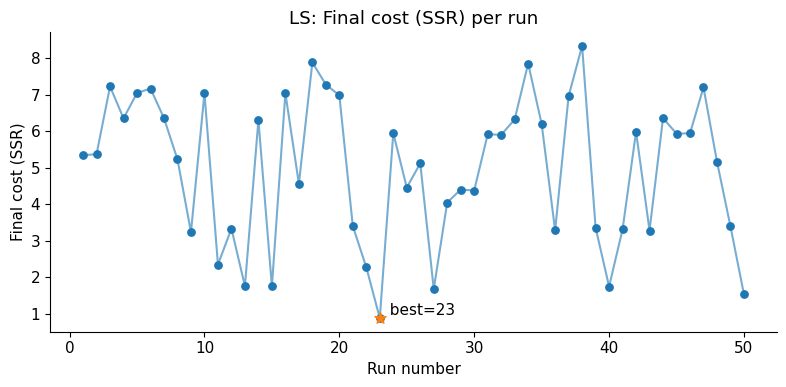

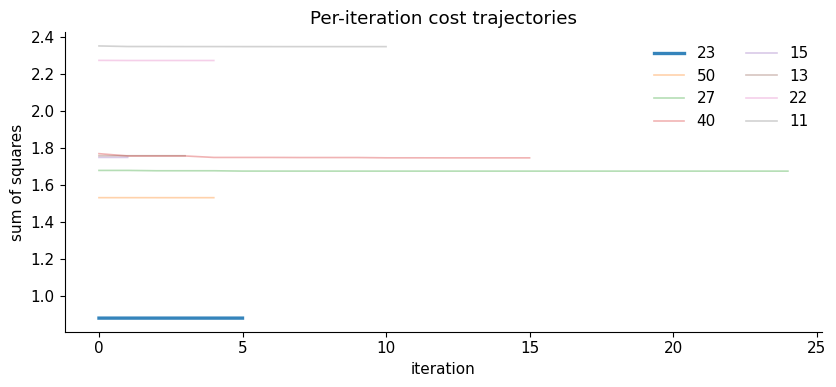

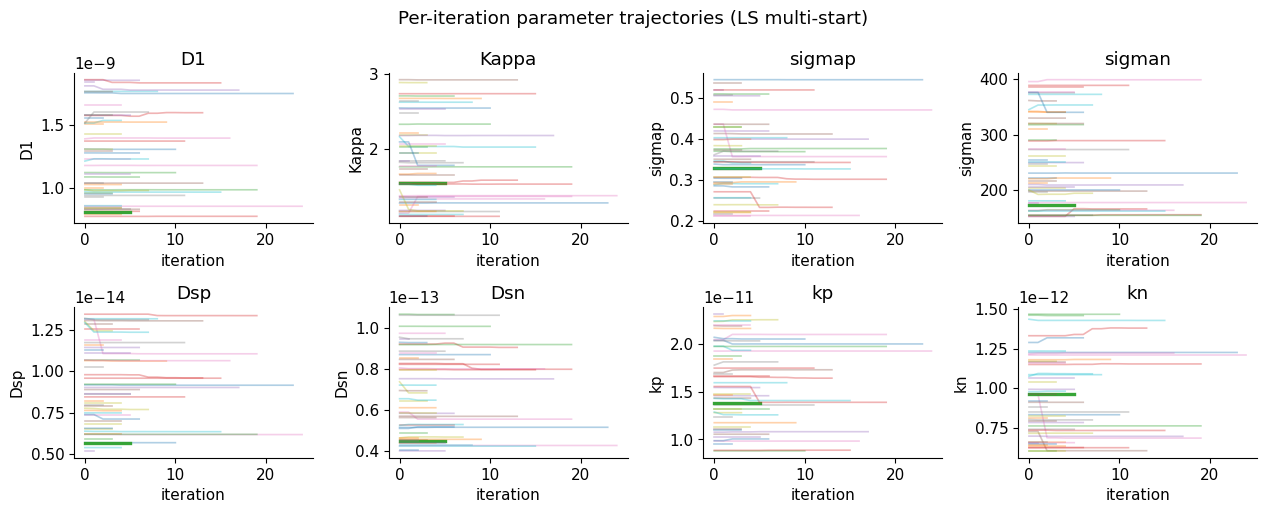

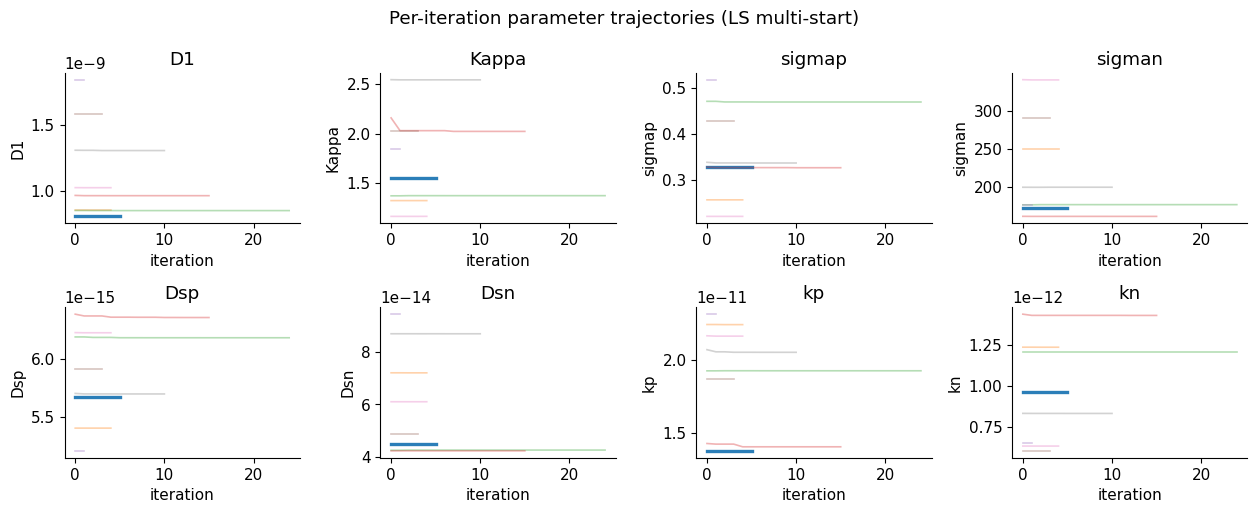

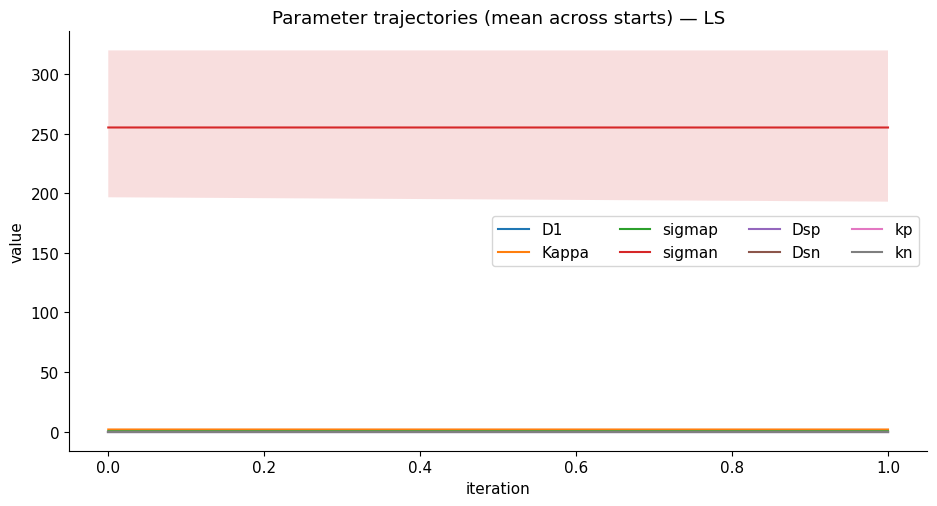

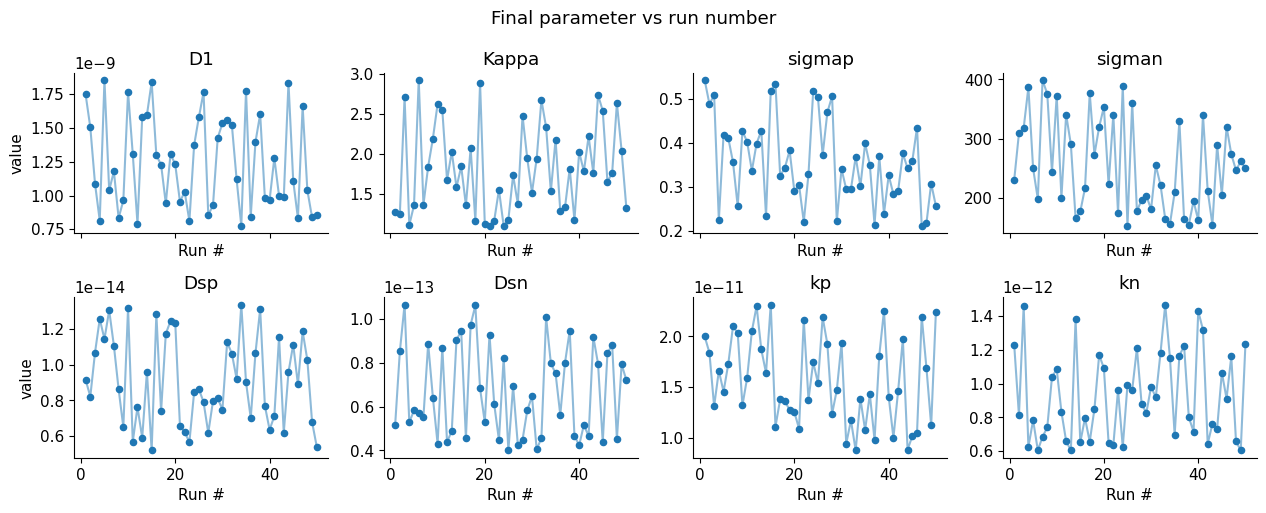


Best-fit vs nominal (LS):
  D1     : est=8.11584e-10, nominal=7.2296e-10, rel_err=1.226e-01
  Kappa  : est=1.551, nominal=1.0794, rel_err=4.369e-01
  sigmap : est=0.329638, nominal=0.2029, rel_err=6.246e-01
  sigman : est=173.458, nominal=150.5, rel_err=1.525e-01
  Dsp    : est=5.66673e-15, nominal=5.2e-15, rel_err=8.976e-02
  Dsn    : est=4.47631e-14, nominal=3.975e-14, rel_err=1.261e-01
  kp     : est=1.37982e-11, nominal=8.6225e-12, rel_err=6.003e-01
  kn     : est=9.62791e-13, nominal=5.9673e-13, rel_err=6.134e-01

[LS] ||residual||_2 = 0.938817, status: 3


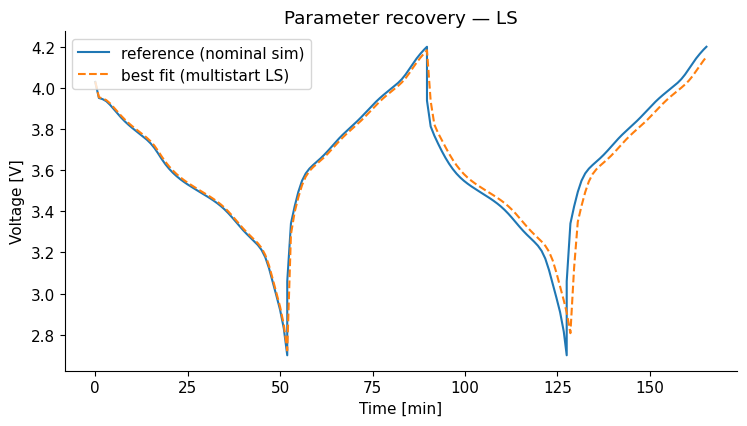

In [29]:

# -------------------------------------- #
# 8) Least-squares demo & visualization  #
# -------------------------------------- #
# 1) Run LS multi-start
est_params_ls, res_ls, runs_ls = run_least_squares(
    t_meas=t_meas,
    V_meas=V_meas,
    template_params=params,
    lower_phys=lower_phys,
    upper_phys=upper_phys,
    keys=vary_keys,
    n_starts=50,          # tweak as needed
    seed=None,            # None = random; int = fixed seed, now non-deterministic
    max_nfev=80,
    tol=1e-9,
    truth_for_eval=params,
)

# 2) Quick console summary
print_runs_summary(runs_ls, keys=vary_keys, truth=params)

# 3) Check that all initial guesses live in [0,1]
check_initial_guesses_in_unit_cube(runs_ls)

# 4) Supervisor request: run # vs final value (SSR by default)
plot_run_vs_final_value(runs_ls, y="cost", logy=False,
                        title="LS: Final cost (SSR) per run")
# If you prefer the residual 2-norm on Y:
# plot_run_vs_final_value(runs_ls, y="norm", title="LS: Final residual norm per run")

# # 5) Compact dispersion of final parameter estimates across runs
# #    (log10(est/nominal); zero line = nominal)
# top_k = min(10, len(runs_ls))
# boxplot_final_params(runs_ls, keys=vary_keys, template=params,
#                      scale=None, top_k=top_k)

# 6) Cost path spaghetti → show only best K runs for readability
bestK = top_k_runs_by_cost(runs_ls, k=min(8, len(runs_ls)))
plot_cost_paths(bestK, logy=False, legend_loc="upper right")

# 7) (Optional) Parameter trajectories:
#    a) grid = detailed per-iteration paths (best K runs only)
plot_param_trajectories_grid(runs_ls, keys=vary_keys, template=params, scale=None)
plot_param_trajectories_grid(bestK, keys=vary_keys, template=params, scale=None)
#    b) single-axis = mean across **all** starts (kept because it’s compact)
plot_param_trajectories_single_axis(runs_ls, keys=vary_keys, template=params, scale=None)

# 8) Best-fit overlay vs nominal
t_fit, V_fit, _ = simulate_voltage(est_params_ls)
if (t_fit.shape != t_meas.shape) or (not np.allclose(t_fit, t_meas)):
    V_fit = align_to(t_fit, V_fit, t_meas)
    
scatter_final_params_vs_run(runs_ls, keys=vary_keys, template=params, scale=None)

print("\nBest-fit vs nominal (LS):")
for k in vary_keys:
    rel_err = abs(est_params_ls[k] - params[k]) / max(abs(params[k]), 1e-30)
    print(f"  {k:7s}: est={est_params_ls[k]:.6g}, nominal={params[k]:.6g}, rel_err={rel_err:.3e}")
print(f"\n[LS] ||residual||_2 = {np.linalg.norm(res_ls.fun):.6g}, status: {res_ls.status}")

plt.figure()
plt.plot(t_meas / 60, V_meas, label="reference (nominal sim)")
plt.plot(t_meas / 60, V_fit, "--", label="best fit (multistart LS)")
plt.xlabel("Time [min]"); plt.ylabel("Voltage [V]")
plt.title("Parameter recovery — LS")
plt.legend(); plt.tight_layout(); plt.show()


#Checktheinitialguesswithetheplot,makesuretheinitialguessmatchestheplot,verifytheinitialguessisthatplot

In [30]:
# -------------------------------------- #
# 9) Optional PSO / DE runs + overlays   #
# -------------------------------------- #
RUN_PSO = False
RUN_DE  = False
FAST_MODE = False # set to True for faster (but less accurate) runs
workers = -1 # toggle between 1 and -1, 1 for one core, -1 for all available cores

pso_runs = []
de_runs  = []

if RUN_PSO:
    pso_est, pso_cost, pso_x, pso_hist, pso_runs = fit_pso(
        t_meas, V_meas, params, lower_phys, upper_phys,
        keys=vary_keys,
        swarm_size=6 if FAST_MODE else 24,
        iters=5 if FAST_MODE else 40,
        seed=123, use_cache=True
    )
    print("\n[PSO] best cost (sum of squares):", pso_cost)

if RUN_DE:
    de_est, de_cost, de_x, de_hist, de_runs = fit_de(
        t_meas, V_meas, params, lower_phys, upper_phys,
        keys=vary_keys,
        maxiter=5 if FAST_MODE else 40,
        popsize=4 if FAST_MODE else 14,
        seed=123,
        workers= workers,
        use_cache=True # maxiter=40, popsize=14  workers=-1 == uses all available cores

    )
    print("\n[DE] best cost (sum of squares):", de_cost)

# === Visualize parameter paths ===
if pso_runs:
    # grid of all parameters (gbest & mean appear as separate "starts")
    plot_param_trajectories_grid(pso_runs, keys=vary_keys, template=params, scale="logrel")
    # single-axis (mean across the two "starts"; you can also pass just [pso_runs[0]] to show gbest only)
    plot_param_trajectories_single_axis(pso_runs, keys=vary_keys, template=params, scale="logrel")

if de_runs:
    plot_param_trajectories_grid(de_runs, keys=vary_keys, template=params, scale="logrel")
    plot_param_trajectories_single_axis(de_runs, keys=vary_keys, template=params, scale="logrel")

# Existing overlays and cost histories
if RUN_PSO or RUN_DE:
    plt.figure()
    plt.plot(t_meas / 60, V_meas, label="reference (nominal sim)")
    _overlay_fit("LS best", est_params_ls, t_meas, V_meas)
    if RUN_PSO and "pso_est" in globals():
        _overlay_fit("PSO best", pso_est, t_meas, V_meas)
    if RUN_DE and "de_est" in globals():
        _overlay_fit("DE best", de_est, t_meas, V_meas)
    plt.xlabel("Time [min]")
    plt.ylabel("Voltage [V]")
    plt.title("Parameter recovery — overlays (PSO / DE / LS)")
    plt.legend()
    plt.tight_layout()
    plt.show()

if RUN_PSO and "pso_hist" in globals():
    _plot_history(pso_hist, "PSO best-cost per iteration")
if RUN_DE and "de_hist" in globals():
    _plot_history(de_hist, "DE best-cost per iteration")
    
    
if pso_runs:
    plot_run_vs_final_value(pso_runs, y="cost", title="PSO: Final cost per run")
    boxplot_final_params(pso_runs, keys=vary_keys, template=params, scale="logrel", top_k=None)

if de_runs:
    plot_run_vs_final_value(de_runs, y="cost", title="DE: Final cost per run")
    boxplot_final_params(de_runs, keys=vary_keys, template=params, scale="logrel", top_k=None)



In [31]:
# plot_param_trajectories_grid(runs_ls + pso_runs + de_runs, keys=vary_keys, template=params, scale="logrel")

In [32]:
# plot_cost_paths(runs_ls + pso_runs + de_runs)

### Cache maintenance
Run this cell if you change **data**, **bounds**, or **nominal parameters**.

In [33]:
# --- Final cleanup: clear any cached objective evaluations ---
try:
    clear_objective_cache()
    print("Objective cache cleared.")
except NameError:
    print("No clear_objective_cache() found; skipping.")

Objective cache cleared.


In [34]:
# def V_error(params_vec,y_meas):
#     # handle parameters 
#     # handle the dict to be in array format
#     # Can we recover the optimal parameters
#     # xo initial guess
#     # errors goes to zero and does it go to the true parameters
#     sol, sim = run_spme(params)
#     y_sim = sol["Terminal voltage [V]"].entries
    
#     return y_meas - y_sim



In [35]:
# rng = np.random.default_rng(123)

# for ii in range(4):
#     x0 = rng.uniform(0.0, 1.0, size=len(vary_keys))
#     print(x0)

In [36]:
import IPython

# This will tell Jupyter to save the notebook in place
IPython.display.display(IPython.display.Javascript('IPython.notebook.save_checkpoint();'))


<IPython.core.display.Javascript object>